In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import networkx as nx
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from torch_geometric.datasets import TUDataset
import torch_geometric as pyg
import math
from einops import einsum

from mil.data.mnist import Bag, MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, detach, human_format
from mil.utils.bag import BagToTorchGeometric
from mil.models import MILModel
from mil.models.fourier_positional_encoding import LearnableFourierPositionalEncoding
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.models.attention import WeightedAverageAttention, MultiHeadAttention
from mil.models.set_transformer import SetTransformer, InducedSetTransformer, SAB, ISAB

/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MNIST bags / MNIST collage

This notebook trains models on variations of the *mnist-bags*, *multi-mnist-bags*, and *mnist-collage* datasets. 
The goal of this notebook is to see which models are able to overfit on these datasets.


The following cell defines three variables, `DATASET`, `TARGET_NUMBERS` and `MODEL` which can be used to run different dataset/model configurations.

`DATASET`:
- `OneHotMNISTBags`: one-hot version of *mnist-bags*, where the dataset yields 10-dimensional one-hot encoded feature vectors directly (i.e. we are not yet working with MNIST digits)
- `MNISTBags`: the *mnist-bags* dataset
- `OneHotMNISTCollage`: one-hot version of *mnist-collage*
- `MNISTCollage`: *mnist-collage* dataset

`TARGET_NUMBERS`:
- `0` corresponds to the *mnist-bags* dataset
- `(0, 1)` corresponds to the *multi-mnist-bags* dataset

`MODELS`:
- `"mean_pool"`: simple baseline that uses mean pooling. Works neither dataset.
- `"max_pool"`: simple baseline that uses max pooling. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"weighted_average_attention"`: uses attention mechanism from "Attention Based Deep Multiple Instance Learning" paper which can only "focus" on one target number at a time. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"self_attention_mean_pooling"`: uses a single transformer layer (self attention) followed by mean pooling. Works for both datasets.
- `"self_attention_max_pooling"`: uses a single transformer layer (self attention) followed by max pooling. Works for both datasets (but better than mean pooling).


Try changing `DATASET`, `TARGET_NUMBERS` and `MODELS` below and rerunning the notebook.

In [2]:
# DATASET = OneHotMNISTBags
# DATASET = MNISTBags
# DATASET = OneHotMNISTCollage
DATASET = MNISTCollage
# DATASET = TUDataset

DATASET_KWARGS = dict()
DATASET_KWARGS = dict(root=f"tmp/dataset", name="COIL-RAG", use_edge_attr=True, use_node_attr=True, cleaned=False)

IS_MIL_DATASET = "mnist" in DATASET.__name__.lower()
IS_GRAPH_DATASET = not IS_MIL_DATASET
IS_BINARY_CLASSIFICATION = IS_MIL_DATASET
IS_MULTICLASS_CLASSIFICATION = not IS_BINARY_CLASSIFICATION

# TARGET_NUMBERS = (0)
TARGET_NUMBERS = (0, 1)

# MODEL = "mean_pool"
# MODEL = "max_pool"
# MODEL = "weighted_average_attention"
# MODEL = "self_attention_mean_pool"
# MODEL = "self_attention_max_pool"
# MODEL = "distance_aware_attention_max_pool"
MODEL = "rel_pos_self_attention_max_pool"
# MODEL = "self_attention_xy_pe_max_pool"
# MODEL = "self_attention_fourier_pe_max_pool"
# MODEL = "set_transformer"
# MODEL = "induced_set_transformer"
# MODEL = "sab_max_pool"
# MODEL = "isab_max_pool"
# MODEL = "gcn_max_pool"
# MODEL = "dense_gcn_max_pool"
# MODEL = "gat_max_pool"

# Only for collages
COLLAGE_SIZE = 256
MIN_DIST = 20

NUM_DIGITS = 10
if DATASET.__name__.startswith("OneHot"):
    FEATURE_SIZE = NUM_DIGITS # must be NUM_DIGITS due to one-hot encoding
    HIDDEN_DIM = 10
else:
    FEATURE_SIZE = 32
    HIDDEN_DIM = 10
if "TUDataset" in DATASET.__name__:
    FEATURE_SIZE = 64

In [3]:
datasets = dict()

if "MNIST" in DATASET.__name__:
    for train in (True, False):
        extra_kwargs = {}
        if "Collage" in DATASET.__name__:
            extra_kwargs["collage_size"] = COLLAGE_SIZE
            extra_kwargs["min_dist"] = MIN_DIST
        ds = DATASET(target_numbers=TARGET_NUMBERS, # target number
                    num_digits=NUM_DIGITS, # sample from all 10 MNIST digits
                    mean_bag_size=10, # mean bag length
                    var_bag_size=2, # variance of bag length
                    num_bags=300 if train else 100, # number of bags
                    seed=1,
                    train=train,
                    **extra_kwargs)
        datasets["train" if train else "test"] = ds
elif "TUDataset" in DATASET.__name__:
    def transform(data):
        data.y = torch.nn.functional.one_hot(data.y[0], num_classes=100).float()
        return data
    ds = DATASET(**DATASET_KWARGS, transform=transform)
    ds = ds.shuffle()
    datasets["train"] = ds[:int(len(ds) * 0.8)]
    datasets["test"] = ds[int(len(ds) * 0.8):]
else:
    raise ValueError(f"Unknown dataset: {DATASET.__name__}")

def make_data_loader(train: bool = True):
    """Utility function to create a data loader for the dataset."""
    ds = datasets["train" if train else "test"]
    return torch.utils.data.DataLoader(ds, batch_size=1, shuffle=train, collate_fn=lambda x: x[0])

## Define the model

The three parts of the MIL model are:
1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual *mnist-bags* dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [4]:
class OneHotFeatureExtractor(nn.Module):
    def forward(self, bag: Bag):
        # In the case of OneHotBags, the instances are already the features.
        return bag.instances

class CNNFeatureExtractor(nn.Module):
    def __init__(self, feature_size: int):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(.1),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(-3, -1),
            nn.Dropout(.5),
            nn.Linear(20 * 4 * 4, feature_size),
            nn.ReLU()
        )

    def forward(self, bag: Bag):
        return self.cnn(bag.instances)

class GNN(nn.Module):
    """GNN model.
    
    The layer parameter can be used to specify the type of GNN layer to use (e.g. pyg.nn.GCNConv, pyg.nn.GATConv, pyg.nn.DenseGCNConv).
    """

    def __init__(self, feature_size: int, hidden_dim: int, layer=pyg.nn.GCNConv):
        super().__init__()
        self.layer = layer
        self.gnn = pyg.nn.Sequential('x, connectivity', [
            (layer(feature_size, hidden_dim), 'x, connectivity -> x'),
            nn.ReLU(inplace=True),
            (layer(hidden_dim, feature_size), 'x, connectivity -> x'),
            nn.ReLU(inplace=True),
        ])

    def forward(self, data: pyg.data.Data):
        number_of_nodes = data.num_nodes
        
        # Assume complete graph
        edge_index = np.array(nx.complete_graph(number_of_nodes).edges).T # complete (directed) graph
        edge_index = np.concatenate([edge_index, edge_index[::-1]], axis=-1) # undirected graph

        # Use distance-based edge weights to drop out edges
        pos = data.pos
        if pos is not None:
            edge_weights = data.edge_attr.squeeze(-1)

            if False: # NOTE (Georg): This is not working yet
                # normalise
                # NOTE (Georg): data.edge_attr is already normalised
                print(edge_weights)
                scaler = preprocessing.MinMaxScaler()
                edge_weights = scaler.fit_transform(edge_weights.reshape(-1, 1)).reshape(1, -1)[0]
                print("Normalized ", edge_weights)

                # drop-out edge based on edge weights
                print(edge_index)
                tau = 0.5
                ei_1 = edge_index[0][(edge_weights < tau)]
                ei_2 = edge_index[1][(edge_weights < tau)]
                edge_index = np.array([ei_1, ei_2])

            # Assume fully connected graph
            if self.layer == pyg.nn.DenseGCNConv:
                # DenseGCNConv requires a dense adjacency matrix                
                connectivity = torch.ones((number_of_nodes, number_of_nodes))
                connectivity = connectivity - torch.diag(torch.ones(number_of_nodes))
            else:
                connectivity = data.edge_index
 
        batch = torch.tensor([0] * number_of_nodes)
        x = self.gnn(data.x, connectivity)
        x = pyg.nn.global_max_pool(x, batch)
        return x

class DistanceKV(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int, bias: bool = True):
        super().__init__()
        self.keys = nn.Linear(feature_size, hidden_dim, bias=bias)
        self.queries = nn.Linear(feature_size, hidden_dim, bias=bias)
        self.relu = nn.ReLU()
        # self.relu = nn.LeakyReLU(.1)
    
    def forward(self, features):
        k = self.keys(features)
        q = self.queries(features)
        D = q @ k.transpose(-2, -1)
        D = self.relu(D)
        return D

class DistanceAwareAttentionHead(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int):
        super().__init__()
        self.keys = nn.Linear(feature_size, hidden_dim, bias=False)
        self.queries = nn.Linear(feature_size, hidden_dim, bias=False)
        self.values = nn.Linear(feature_size, feature_size, bias=False)

        self.dist_tradeoff = nn.Parameter(torch.ones(1))
        self.distkv = DistanceKV(feature_size, hidden_dim) # TODO: check if we need bias=True
        self.dropout = nn.Dropout(.1)

    def forward(self, data: pyg.data.Data):
        features = data.x
        H = features  # NxL
        L = features.shape[-1]

        self.dist = dist = pyg.utils.to_dense_adj(data.edge_index, edge_attr=data.edge_attr.squeeze(-1), max_num_nodes=data.num_nodes).squeeze(0)
        
        # Compute distance-aware attention scores
        D = self.D = self.distkv(features) # NxN

        # Compute key, query, value vectors
        k = self.keys(H)  # NxD
        q = self.queries(H)  # NxD
        v = self.values(H)  # NxL

        # Compute attention scores (dot product)
        A = q @ k.transpose(-2, -1)  # NxN

        # Scale by sqrt(L)
        A = A / L**.5
        self.A0 = A

        # Combine with distance-aware attention scores
        A = A - self.dist_tradeoff * dist * D

        # Softmax over N
        A = F.softmax(A, dim=-1)  # NxN

        # Retain attention weights for visualization
        self.A = A

        # Apply dropout
        A = self.dropout(A)

        # Apply attention weights to values
        M = A @ v # NxL

        data.update(dict(x=M)) # NOTE: modifies data in-place
        return data

class RelativePositionAttentionHead(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int):
        super().__init__()
        self.keys = nn.Linear(feature_size, hidden_dim, bias=False)
        self.queries = nn.Linear(feature_size, hidden_dim, bias=False)
        self.values = nn.Linear(feature_size, feature_size, bias=False)

        h = 2 # hidden_dim
        self.rel_rep_k = nn.Sequential(
            nn.Linear(1, h),
            nn.Tanh(),
            nn.Linear(h, hidden_dim)
        )
        self.rel_rep_v = nn.Sequential(
            nn.Linear(1, h),
            nn.Tanh(),
            nn.Linear(h, feature_size)
        )
        
        self.dropout = nn.Dropout(.1)

    def forward(self, data: pyg.data.Data):
        features = data.x
        N = features.shape[0]
        H = features  # NxL
        L = features.shape[-1]
        
        rk = self.rel_rep_k(data.edge_attr) # num_edges x D
        rv = self.rel_rep_v(data.edge_attr) # num_edges x D

        self.dist = dist = pyg.utils.to_dense_adj(data.edge_index, edge_attr=data.edge_attr.squeeze(-1), max_num_nodes=data.num_nodes).squeeze(0) # NxN

        Rk = pyg.utils.to_dense_adj(data.edge_index, edge_attr=rk, max_num_nodes=data.num_nodes).squeeze(0) # NxNxD
        Rv = pyg.utils.to_dense_adj(data.edge_index, edge_attr=rv, max_num_nodes=data.num_nodes).squeeze(0) # NxNxD

        # Compute key, query, value vectors
        k = self.keys(H)  # NxD
        q = self.queries(H)  # NxD
        v = self.values(H)  # NxL

        # Compute attention scores (dot product)
        A = q @ k.transpose(-2, -1)  # NxN

        q_repeat = q.unsqueeze(1).repeat(1, N, 1) # NxNxD # TODO: check if this is the correct dimension
        A = A + (q_repeat * Rk).sum(axis=-1) # NxN

        # Scale by sqrt(L)
        A = A / L**.5
        self.A0 = A

        # Softmax over N
        A = F.softmax(A, dim=-1)  # NxN

        # Retain attention weights for visualization
        self.A = A

        # Apply dropout
        A = self.dropout(A)

        # Apply attention weights to values
        M = A @ v # NxL

        M = M + (A.unsqueeze(-1) * Rv).sum(axis=-2) # NxL # TODO: check if this is the correct dimension

        data.update(dict(x=M)) # NOTE: modifies data in-place
        return data
    
class XYPositionalEncoding(nn.Module):

    def __init__(self, feature_size: int, dropout: float = 0.):
        super().__init__()
        assert feature_size % 4 == 0
        self.div_term = torch.exp(torch.arange(0, feature_size, 4) * (-math.log(10000.0) / feature_size))
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        pos = data.pos
        pos_x, pos_y = pos.moveaxis(-1, 0).unsqueeze(-1)
        x = data.x
        div_term = self.div_term

        pe = torch.zeros_like(x)
        pe[..., 0::4] = torch.sin(pos_x * div_term)
        pe[..., 1::4] = torch.cos(pos_x * div_term)
        pe[..., 2::4] = torch.sin(pos_y * div_term)
        pe[..., 3::4] = torch.cos(pos_y * div_term)

        x = x + pe
        pe = self.dropout(x)
        data.update(dict(x=x)) # NOTE: modifies data in-place
        return data

class FourierPositionalEncoding(nn.Module):

    def __init__(self, feature_size: int, pos_dim: int = 2):
        super().__init__()
        self.enc = LearnableFourierPositionalEncoding(
            G=1,
            M=pos_dim,
            F_dim=16,
            H_dim=16, # hidden layer size
            D=feature_size,
            gamma=10
        )
        
    def forward(self, data):
        pos = data.pos.unsqueeze(-2) # Nx1x2 (expand group dimension)
        enc = self.enc(pos)
        x = data.x + enc
        data.update(dict(x=x)) # NOTE: modifies data in-place
        return data

class Aggregate(nn.Module):
    """Simple pooling layer for mean/max pooling."""
    def __init__(self, pool: str = "mean", dim: int = 0):
        super().__init__()
        self.pool = pool
        self.dim = dim

    def forward(self, x):
        pool = getattr(torch, self.pool)
        result = pool(x, dim=self.dim)
        if self.pool == "max":
            result = result.values
        return result

class Select(nn.Module):
    """Simple layer for selecting a single attribute, i.e. selecting the `x` attribute from a `Data` object."""
    def __init__(self, attr: str):
        super().__init__()
        self.attr = attr

    def forward(self, x):
        return getattr(x, self.attr)

class Classifier(nn.Sequential):
    def __init__(self, feature_size: int, output_size: int = 1):
        super().__init__(
            nn.Linear(feature_size, output_size),
            nn.Sigmoid()
        )
    
class SqueezeUnsqueeze(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.module = module

    def forward(self, x):
        return self.module(x.unsqueeze(0)).squeeze(0)

# Keep track of attention layer for visualization
attention_layer = None

####################
# Define model
####################

# Feature extractor
feature_extractor = OneHotFeatureExtractor() if DATASET.__name__.startswith("OneHot") else CNNFeatureExtractor(feature_size=FEATURE_SIZE)

# Convert bag and extracted features to graph
converter = BagToTorchGeometric(collage_size=COLLAGE_SIZE, compute_edge_index=True, compute_edge_attr="collage" in DATASET.__name__.lower())

# Classifier
classifier = Classifier(feature_size=FEATURE_SIZE)

# Pooler
if MODEL == "mean_pool":
    pooler = nn.Sequential(Select("x"), Aggregate("mean"))
elif MODEL == "max_pool":
    pooler = nn.Sequential(Select("x"), Aggregate("max"))
elif MODEL == "weighted_average_attention":
    attention_layer = WeightedAverageAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pooler = nn.Sequential(Select("x"), attention_layer)
elif MODEL == "self_attention_mean_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pooler = nn.Sequential(Select("x"), attention_layer, Aggregate("mean"))
elif MODEL == "self_attention_max_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pooler = nn.Sequential(Select("x"), attention_layer, Aggregate("max"))
elif MODEL == "distance_aware_attention_max_pool":
    attention_layer = DistanceAwareAttentionHead(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pooler = nn.Sequential(attention_layer, Select("x"), Aggregate("max"))
elif MODEL == "rel_pos_self_attention_max_pool":
    attention_layer = RelativePositionAttentionHead(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pooler = nn.Sequential(attention_layer, Select("x"), Aggregate("max"))
elif MODEL == "self_attention_xy_pe_max_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    positional_encoding = XYPositionalEncoding(feature_size=FEATURE_SIZE)
    pooler = nn.Sequential(positional_encoding, Select("x"), attention_layer, Aggregate("max"))
elif MODEL == "self_attention_fourier_pe_max_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    positional_encoding = FourierPositionalEncoding(feature_size=FEATURE_SIZE)
    pooler = nn.Sequential(positional_encoding, Select("x"), attention_layer, Aggregate("max"))
elif MODEL == "set_transformer":
    pooler = nn.Sequential(Select("x"), SetTransformer(dim_input=FEATURE_SIZE, num_outputs=1, dim_output=1, dim_hidden=HIDDEN_DIM, num_heads=1))
    classifier=nn.Sigmoid()
elif MODEL == "induced_set_transformer":
    pooler = nn.Sequential(Select("x"), InducedSetTransformer(dim_input=FEATURE_SIZE, num_outputs=1, dim_output=1, dim_hidden=HIDDEN_DIM, num_heads=1, num_inds=32))
    classifier=nn.Sigmoid()
elif MODEL == "sab_max_pool":
    pooler = nn.Sequential(Select("x"), SqueezeUnsqueeze(SAB(dim_in=FEATURE_SIZE, dim_out=FEATURE_SIZE, num_heads=1)), Aggregate("max"))
elif MODEL == "isab_max_pool":
    pooler = nn.Sequential(Select("x", SqueezeUnsqueeze(ISAB(dim_in=FEATURE_SIZE, dim_out=FEATURE_SIZE, num_heads=1, num_inds=32)), Aggregate("max")))
elif MODEL == "gcn_max_pool":
    pooler = gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.GCNConv)
elif MODEL == "dense_gcn_max_pool":
    pooler = gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.DenseGCNConv)
elif MODEL == "gat_max_pool":
    pooler = gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.GATConv)
else:
    raise ValueError(f"Unknown model {MODEL}")

# Define model
if IS_MIL_DATASET:
    model = MILModel(feature_extractor=feature_extractor,
                    converter=converter,
                    pooler=pooler,
                    classifier=classifier)
elif IS_GRAPH_DATASET:
    classifier = Classifier(feature_size=FEATURE_SIZE, output_size=100)
    model = nn.Sequential(pooler, classifier)
else:
    raise ValueError(f"Unknown dataset type {DATASET.__name__}")

## Define loss function and optimizer

We use binary cross-entropy loss.

In [5]:
loss_function = nn.BCELoss() if IS_BINARY_CLASSIFICATION else nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

def error_score(y_pred, y):
    if IS_BINARY_CLASSIFICATION:
        return 1. - ((y_pred > .5).float() == y).cpu().detach().float()
    else:
        return 1. - (y_pred.argmax() == y.argmax()).cpu().detach().float()

Helper code to evaluate on test set:

In [6]:
test_loader = make_data_loader(train=False)

def test_loss_and_error(model, loader):
    model.eval()

    total_loss = 0.
    total_error = 0.
    predictions = []

    with torch.no_grad():
        for i, bag in enumerate(loader):
            bag = device(bag)
            y = bag.y.float()

            # Calculate loss and metrics
            y_pred = model(bag).squeeze()
            loss = loss_function(y_pred, y)

            predictions.append((detach(device(bag, "cpu")), y_pred.detach().cpu()))

            error = error_score(y_pred, y)
            total_error += error
            total_loss += loss.detach().cpu()
    return total_loss / len(loader), total_error / len(loader), predictions

## Train

Training model with 17.4K parameters


/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch:   0, loss: 0.7039, error: 0.5633, test_loss: 0.6972, test_error: 0.5000
Epoch:   1, loss: 0.6991, error: 0.5000, test_loss: 0.6952, test_error: 0.5000
Epoch:   2, loss: 0.6906, error: 0.4600, test_loss: 0.6866, test_error: 0.5000
Epoch:   3, loss: 0.6768, error: 0.3667, test_loss: 0.6680, test_error: 0.4200
Epoch:   4, loss: 0.6530, error: 0.3733, test_loss: 0.6702, test_error: 0.4100
Epoch:   5, loss: 0.6126, error: 0.3167, test_loss: 0.6401, test_error: 0.3800
Epoch:   6, loss: 0.6087, error: 0.3367, test_loss: 0.6176, test_error: 0.3800
Epoch:   7, loss: 0.5745, error: 0.2867, test_loss: 0.6373, test_error: 0.3900
Epoch:   8, loss: 0.5669, error: 0.2833, test_loss: 0.6305, test_error: 0.3600
Epoch:   9, loss: 0.5172, error: 0.2833, test_loss: 0.5670, test_error: 0.2800
Epoch:  10, loss: 0.5180, error: 0.2933, test_loss: 0.5737, test_error: 0.3000
Epoch:  11, loss: 0.4912, error: 0.2300, test_loss: 0.5503, test_error: 0.2800
Epoch:  12, loss: 0.4736, error: 0.2467, test_loss: 

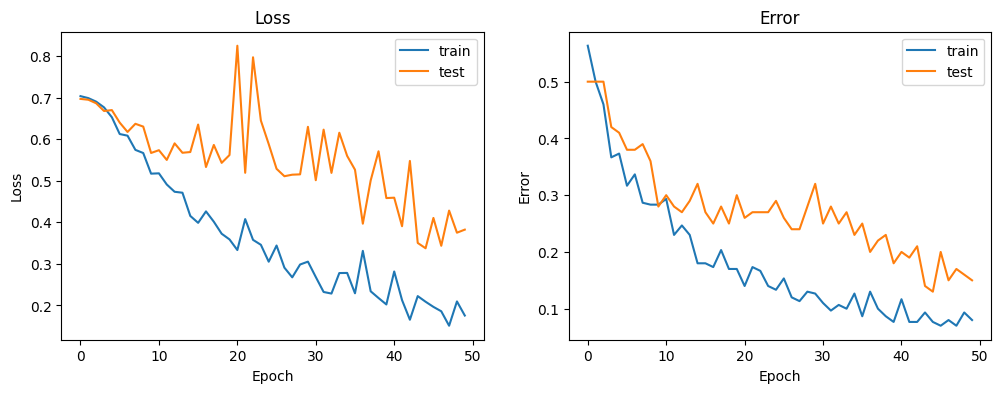

In [7]:
loader = make_data_loader(train=True)

stats = []

model.train()
print(f"Training model with {human_format(sum(p.numel() for p in model.parameters() if p.requires_grad))} parameters")

for epoch in range(50):
    model.train()

    total_loss = 0.
    total_error = 0.
    for bag in loader:
        bag = device(bag)
        y = bag.y

        optimizer.zero_grad()

        # Calculate loss and metrics
        y_pred = model(bag).squeeze()
        loss = loss_function(y_pred, y)

        error = error_score(y_pred, y)
        total_error += error
        
        # Backward pass
        loss.backward()

        total_loss += loss.detach().cpu()
        # Step
        optimizer.step()
    
    test_loss, test_error, _ = test_loss_and_error(model, test_loader)

    stats.append({
        "epoch": epoch,
        "loss": total_loss / len(loader),
        "error": total_error / len(loader),
        "test_loss": test_loss,
        "test_error": test_error
    })
    print(
        f"Epoch: {epoch:3d}, loss: {total_loss/len(loader):.4f}, error: {total_error/len(loader):.4f}, test_loss: {test_loss:.4f}, test_error: {test_error:.4f}")

# Plot training and test loss/error
stats = pd.DataFrame(stats)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(stats["epoch"], stats["loss"], label="train")
plt.plot(stats["epoch"], stats["test_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Error")
plt.plot(stats["epoch"], stats["error"], label="train")
plt.plot(stats["epoch"], stats["test_error"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

## Test

In [8]:
test_loss, test_error, predictions = test_loss_and_error(model, test_loader)
print(f"Test loss: {test_loss:.4f}, test error: {test_error:.4f}")

print_prediction_stats(predictions, target_numbers=TARGET_NUMBERS)

Test loss: 0.3825, test error: 0.1500

                                 % acc    total    -pred    +pred     example
  bags                              85      100       51       49     0 8 3 2 9 1 7
  bags with 0s                      81       83       34       49     0 8 3 2 9 1 7
  bags without 0s                  100       17       17        0     2 8 5 6 8 3 7 6
  bags with 0s and 1s               78       70       21       49     0 8 3 2 9 1 7
  bags with 0s and not 1s          100       13       13        0     6 6 8 3 0 3 6 6 9 4
  bags with 1s                      81       80       31       49     0 8 3 2 9 1 7
  bags without 1s                  100       20       20        0     2 8 5 6 8 3 7 6
  bags with 1s and 0s               78       70       21       49     0 8 3 2 9 1 7
  bags with 1s and not 0s          100       10       10        0     2 2 7 4 1 6 9 5 5 8 6
  bags with 2 key instance(s)       82       46        8       38     0 0 5 8 2 1 9 2 0 6 5
  bags with 3 key

### First 10 bags in test dataset

In [9]:
def plot_dist_aware_attention(bag):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
    plt.subplot(141)
    plt.title("dist")
    plot_attention_head(bag, attention_layer.dist, limit_range=False)
    plt.subplot(142)
    plt.title("D")
    plot_attention_head(bag, attention_layer.D, limit_range=False)
    plt.subplot(143)
    plt.title("A0")
    plot_attention_head(bag, attention_layer.A0)
    plt.subplot(144)
    plt.title("A")
    plot_attention_head(bag, attention_layer.A)

def visualize_prediction(bag, y_pred):
    y = bag.bag_label
    if DATASET == OneHotMNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
            print()
        elif isinstance(attention_layer, MultiHeadAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred>.5)
    elif DATASET == MNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred, attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadAttention):
            plot_bag(bag, y_pred=y_pred)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif DATASET == OneHotMNISTCollage:
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        if isinstance(attention_layer, DistanceAwareAttentionHead):
            plot_dist_aware_attention(bag)
    elif DATASET == MNISTCollage:
        plot_bag(bag, y_pred=y_pred, collage_size=COLLAGE_SIZE)
        if isinstance(attention_layer, DistanceAwareAttentionHead):
            plot_dist_aware_attention(bag)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.bag_label.float()
        y_pred = model(bag).squeeze(0)
        visualize_prediction(bag, y_pred)

AttributeError: 'Bag' object has no attribute 'bag_label'

### First 10 mistakes in test dataset

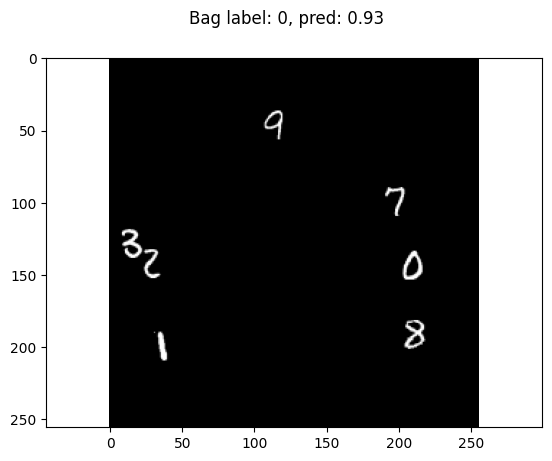

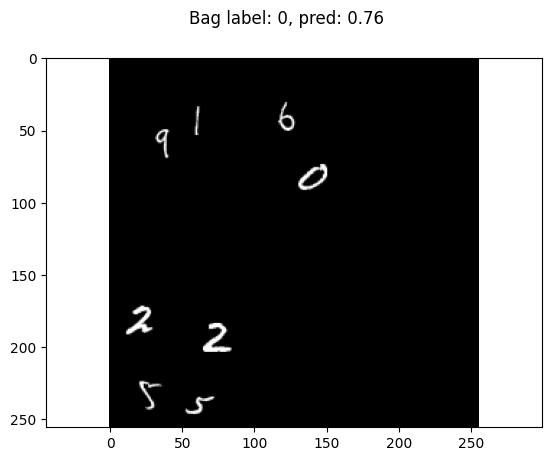

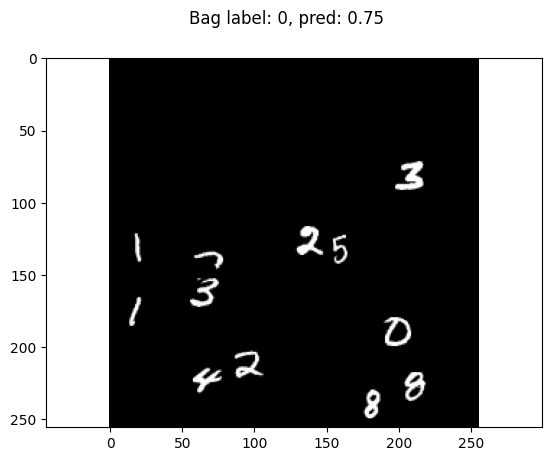

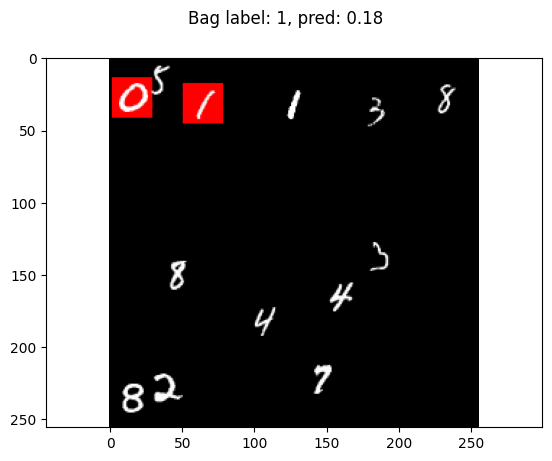

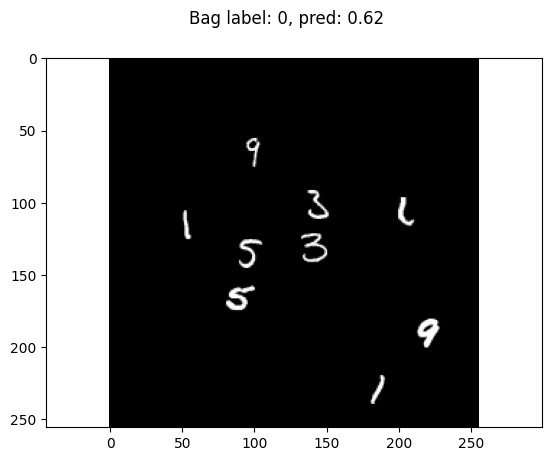

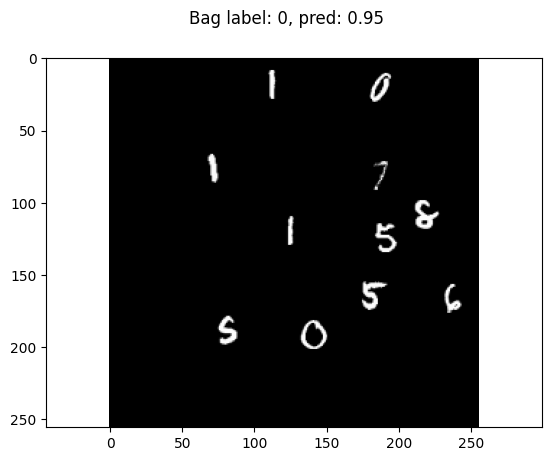

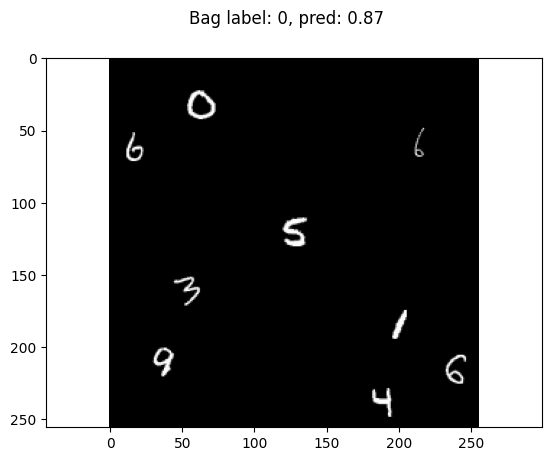

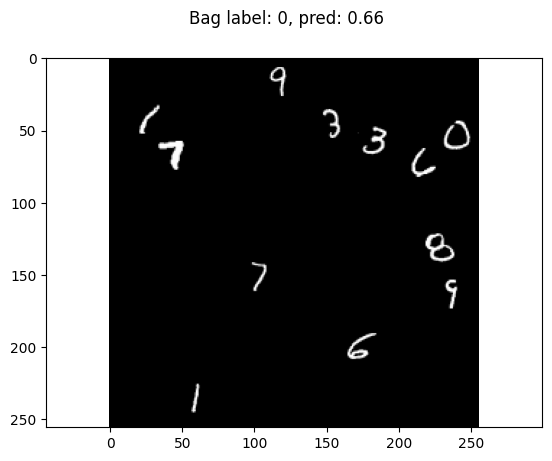

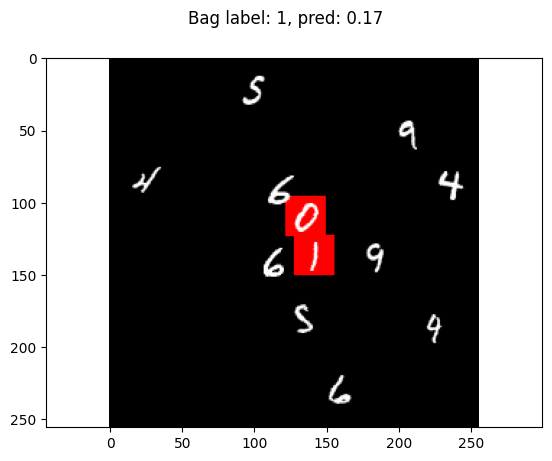

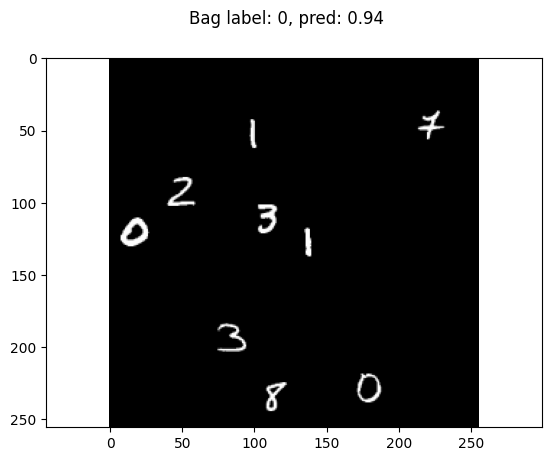

In [ ]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        bag = device(bag)
        y = bag.bag_label.float()
        y_pred = model(bag).squeeze(0)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred)
            i += 1